In [ ]:
# from google.colab import drive
# drive.mount("./gdrive")

Mounted at ./gdrive


In [ ]:
!mkdir ./data
!cp -r "/content/gdrive/MyDrive/Colab Notebooks/ISR/ACRIMA" ./data/

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.model_selection import StratifiedKFold

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
DATASET_PATH = "./data/ACRIMA"

train_dir = DATASET_PATH + "/train"
test_dir = DATASET_PATH + "/test"

def create_data_and_labels(path, label, data, labels):

    for img in os.listdir(path + "/" + label):
        image = cv2.imread(path + "/" + label + "/" + img, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128,128))

        data.append(image)
        labels.append(label)
    return data, labels

X_train = []
y_train = []
X_train, y_train = create_data_and_labels(train_dir, "Non Glaucoma", X_train, y_train)
X_train, y_train = create_data_and_labels(train_dir, "Glaucoma", X_train, y_train)

X_test = []
y_test = []
X_test, y_test = create_data_and_labels(test_dir, "Non Glaucoma", X_test, y_test)
X_test, y_test = create_data_and_labels(test_dir, "Glaucoma", X_test, y_test)

In [ ]:
from sklearn.preprocessing import LabelEncoder

#normalization
X_train = np.array(X_train, dtype = "float") / 255
X_test = np.array(X_test, dtype = "float") / 255

y_train = np.array(y_train)
y_test = np.array(y_test)

#encoding labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (565, 128, 128, 3)
Shape of y_train:  (565,)
Shape of X_test:  (140, 128, 128, 3)
Shape of y_test:  (140,)


In [ ]:
input_shape = (128,128, 3)
num_classes = 2

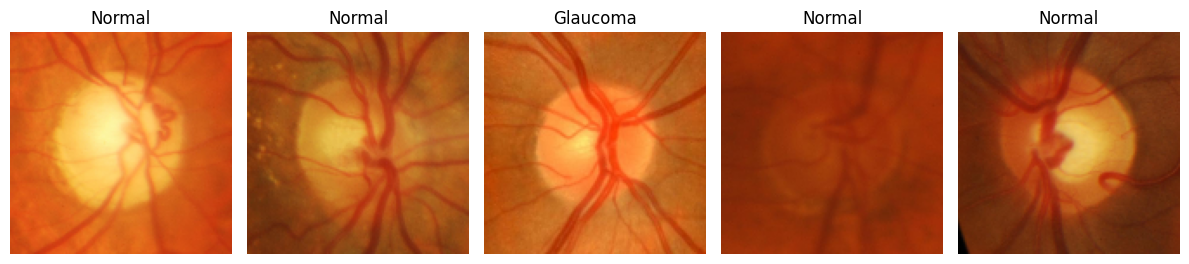

In [ ]:
num_samples = 5
random_indices = np.random.choice(X_train.shape[0], num_samples, replace=False)
samples = X_train[random_indices]
labels = y_train[random_indices]

fig, axs = plt.subplots(1, 5, tight_layout = True, figsize = (12,6), facecolor = 'white')
title = ["Normal", "Glaucoma"]

for i, ax in enumerate(axs.flat):
    ax.imshow(samples[i])
    ax.set_title(title[labels[i]])
    ax.axis('off')
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dropout, MaxPooling2D, Add, Dense, Flatten, Activation
from tensorflow.keras.optimizers import RMSprop, Adam

In [ ]:
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)

# Initialize lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
specificity_scores = []
confusion_matrices = []
histories = []

In [ ]:
def build_model(input_shape, num_classes):
    model = Sequential()

    # input layer
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.6))
    # output layer
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# K-fold Cross Validation model evaluation
for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train, y_train)):
    print(f"Fold {fold+1}/5")

    # Split data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
    y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]

    # Create a new ImageDataGenerator for each fold to ensure randomness
    datagen_fold = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    train_generator_fold = datagen_fold.flow(
        X_train_fold,
        y_train_fold,
        batch_size=64
    )

    # build the model
    model = build_model(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model for the current fold
    history = model.fit(train_generator_fold,
                        epochs=20,
                        verbose=0, # Set verbose to 0 to reduce output during training
                        validation_data=(X_val_fold, y_val_fold))

    histories.append(history)

    # Evaluate the model on the validation data for the current fold
    y_pred_fold = model.predict(X_val_fold)
    y_pred_fold = (y_pred_fold > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    precision = precision_score(y_val_fold, y_pred_fold)
    recall = recall_score(y_val_fold, y_pred_fold)
    f1 = f1_score(y_val_fold, y_pred_fold)
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Handle division by zero

    # Store metrics
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    specificity_scores.append(specificity)
    confusion_matrices.append(cm)

    print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Specificity: {specificity:.4f}")

Fold 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Fold 1 - Accuracy: 0.9115, Precision: 0.8519, Recall: 0.9583, F1 Score: 0.9020, Specificity: 0.8769
Fold 2/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
Fold 2 - Accuracy: 0.9381, Precision: 0.9556, Recall: 0.8958, F1 Score: 0.9247, Specificity: 0.9692
Fold 3/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3 - Accuracy: 0.9469, Precision: 0.9375, Recall: 0.9375, F1 Score: 0.9375, Specificity: 0.9538
Fold 4/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
Fold 4 - Accuracy: 0.8850, Precision: 0.8889, Recall: 0.8333, F1 Score: 0.8602, Specificity: 0.9231
Fold 5/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
Fold 5 - Accuracy: 0.9381, Precision: 0.9348, Recall: 0.9149, F1 Score: 0.9247, Specificity: 0.9545

Average Metrics across all folds:
Average Accuracy: 0.9239
Average Precision: 0.9137
Average Recall: 0.9080
Average F1 Score: 0.9098
Average Specificity: 0.9355
Average Confusion Matrix:
 [[61  4]
 [ 4 43]]


In [ ]:
# Calculate and print average metrics across all folds
print("\nAverage Metrics across all folds:")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average Specificity: {np.mean(specificity_scores):.4f}")
print("Average Confusion Matrix:\n", np.mean(confusion_matrices, axis=0).astype(int)) # Display average confusion matrix as integers


Average Metrics across all folds:
Average Accuracy: 0.9239
Average Precision: 0.9137
Average Recall: 0.9080
Average F1 Score: 0.9098
Average Specificity: 0.9355
Average Confusion Matrix:
 [[61  4]
 [ 4 43]]
